C:\Users\gunes\AppData\Local\Temp\ipykernel_32600\661829846.py:27: RuntimeWarning: invalid value encountered in divide
  separation += diff / (dist ** 2)


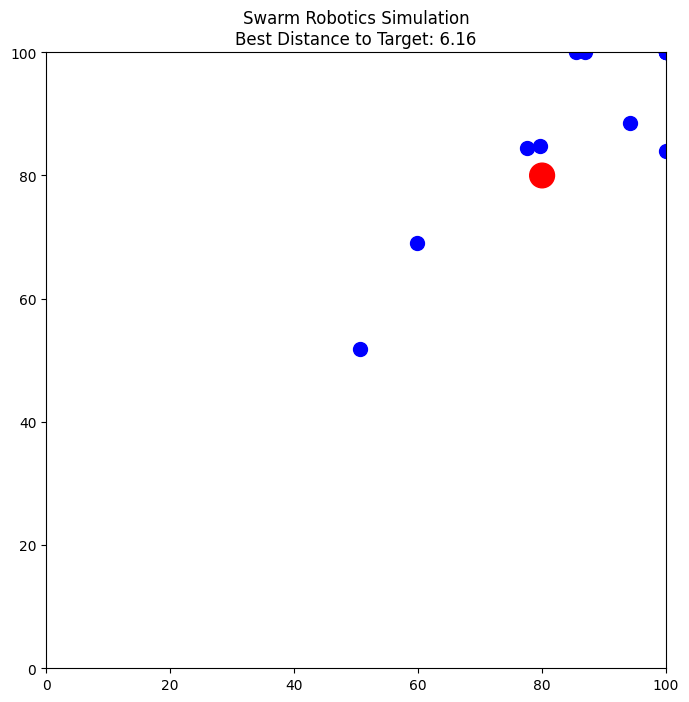

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
from matplotlib.patches import Circle

class SwarmRobot:
    def __init__(self, x, y, environment_size):
        self.position = np.array([x, y])
        self.velocity = np.random.randn(2) * 0.1
        self.best_position = self.position.copy()
        self.environment_size = environment_size
        
    def update(self, global_best, swarm):
        # Parameters for the particle swarm optimization
        w = 0.5  # Inertia weight
        c1 = 1.5  # Cognitive parameter
        c2 = 1.5  # Social parameter
        
        # Calculate separation from other robots
        separation = np.zeros(2)
        for other in swarm:
            if other is not self:
                diff = self.position - other.position
                dist = np.linalg.norm(diff)
                if dist < 2.0:  # Separation radius
                    separation += diff / (dist ** 2)
        
        # Update velocity using PSO formula with additional separation term
        r1, r2 = random.random(), random.random()
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        
        self.velocity = (w * self.velocity + 
                        cognitive + 
                        social + 
                        0.1 * separation)  # Add separation force
        
        # Update position
        self.position += self.velocity
        
        # Boundary conditions
        self.position[0] = np.clip(self.position[0], 0, self.environment_size)
        self.position[1] = np.clip(self.position[1], 0, self.environment_size)
        
        # Update personal best if current position is better
        if self.evaluate_fitness() < self.evaluate_fitness(self.best_position):
            self.best_position = self.position.copy()
    
    def evaluate_fitness(self, pos=None):
        if pos is None:
            pos = self.position
        # Simple fitness function: distance to target
        target = np.array([self.environment_size * 0.8, self.environment_size * 0.8])
        return np.linalg.norm(pos - target)

class SwarmSimulation:
    def __init__(self, num_robots=10, environment_size=100):
        self.num_robots = num_robots
        self.environment_size = environment_size
        self.swarm = []
        self.global_best = None
        self.global_best_value = float('inf')
        self.initialize_swarm()
        
        # Setup visualization
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.scatter = None
        self.target = Circle((environment_size * 0.8, environment_size * 0.8), 
                           2, color='red', fill=True)
        self.ax.add_patch(self.target)
        
    def initialize_swarm(self):
        for _ in range(self.num_robots):
            x = random.uniform(0, self.environment_size)
            y = random.uniform(0, self.environment_size)
            self.swarm.append(SwarmRobot(x, y, self.environment_size))
    
    def update(self, frame):
        # Update global best
        for robot in self.swarm:
            fitness = robot.evaluate_fitness()
            if fitness < self.global_best_value:
                self.global_best_value = fitness
                self.global_best = robot.position.copy()
        
        # Update each robot
        for robot in self.swarm:
            robot.update(self.global_best, self.swarm)
        
        # Update visualization
        positions = np.array([robot.position for robot in self.swarm])
        if self.scatter:
            self.scatter.remove()
        self.scatter = self.ax.scatter(positions[:, 0], positions[:, 1], 
                                     c='blue', s=100)
        self.ax.set_xlim(0, self.environment_size)
        self.ax.set_ylim(0, self.environment_size)
        
        # Add title with current best fitness
        self.ax.set_title(f'Swarm Robotics Simulation\nBest Distance to Target: {self.global_best_value:.2f}')
        
        return self.scatter,

    def animate(self):
        anim = FuncAnimation(self.fig, self.update, frames=200, 
                           interval=50, blit=True)
        plt.show()

# Create and run simulation
simulation = SwarmSimulation(num_robots=15, environment_size=100)
simulation.animate()

### NAVIGATING TO WAYPOINT

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Circle
import os

class SwarmRobot:
    def __init__(self, x, y, environment_size):
        self.position = np.array([x, y])
        self.velocity = np.random.randn(2) * 0.1
        self.best_position = self.position.copy()
        self.environment_size = environment_size
        
    def update(self, global_best, swarm, generation):
        # Parameters that change with generation to show evolution
        w = 0.5 * (1 - generation/200)  # Decreasing inertia
        c1 = 1.5 * (1 + generation/200)  # Increasing cognitive learning
        c2 = 1.5  # Constant social learning
        
        # Calculate forces
        separation = np.zeros(2)
        for other in swarm:
            if other is not self:
                diff = self.position - other.position
                dist = max(np.linalg.norm(diff), 0.1)
                if dist < 2.0:
                    separation += diff / dist
        
        # Update velocity
        r1, r2 = np.random.random(2)
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        
        self.velocity = (w * self.velocity + cognitive + social + 0.1 * separation)
        speed = np.linalg.norm(self.velocity)
        if speed > 2.0:
            self.velocity = (self.velocity / speed) * 2.0
            
        self.position += self.velocity
        self.position = np.clip(self.position, 0, self.environment_size)
        
        if self.evaluate_fitness() < self.evaluate_fitness(self.best_position):
            self.best_position = self.position.copy()
    
    def evaluate_fitness(self, pos=None):
        if pos is None:
            pos = self.position
        target = np.array([self.environment_size * 0.8, self.environment_size * 0.8])
        return np.linalg.norm(pos - target)

class SwarmSimulation:
    def __init__(self, num_robots=15, environment_size=100):
        self.num_robots = num_robots
        self.environment_size = environment_size
        self.swarm = []
        self.global_best = None
        self.global_best_value = float('inf')
        self.fitness_history = []
        self.generation = 0
        
        # Initialize swarm
        for _ in range(num_robots):
            x = np.random.uniform(0, environment_size)
            y = np.random.uniform(0, environment_size)
            self.swarm.append(SwarmRobot(x, y, environment_size))
        
        # Setup figure
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(15, 6))
        self.target = np.array([environment_size * 0.8, environment_size * 0.8])
        
    def update(self, frame):
        self.generation = frame
        
        # Update global best
        for robot in self.swarm:
            fitness = robot.evaluate_fitness()
            if fitness < self.global_best_value:
                self.global_best_value = fitness
                self.global_best = robot.position.copy()
        
        # Update robots
        for robot in self.swarm:
            robot.update(self.global_best, self.swarm, frame)
        
        self.fitness_history.append(self.global_best_value)
        
        # Clear and update plots
        self.ax1.clear()
        self.ax2.clear()
        
        # Plot swarm
        positions = np.array([robot.position for robot in self.swarm])
        self.ax1.scatter(positions[:, 0], positions[:, 1], c='blue', label='Robots')
        self.ax1.scatter(self.target[0], self.target[1], c='red', s=100, label='Target')
        self.ax1.set_xlim(0, self.environment_size)
        self.ax1.set_ylim(0, self.environment_size)
        self.ax1.set_title(f'Generation {frame}')
        self.ax1.legend()
        self.ax1.grid(True)
        
        # Plot fitness history
        self.ax2.plot(self.fitness_history, 'b-', label='Best Fitness')
        self.ax2.set_title('Best Fitness Over Time')
        self.ax2.set_xlabel('Generation')
        self.ax2.set_ylabel('Distance to Target')
        self.ax2.grid(True)
        self.ax2.legend()
        
        plt.tight_layout()
        
        # Print progress
        if frame % 10 == 0:
            print(f"Generation {frame} - Best Fitness: {self.global_best_value:.2f}")

def create_swarm_evolution_gif(num_generations=50, num_robots=15, environment_size=100):
    print("Starting simulation...")
    
    # Create simulation
    sim = SwarmSimulation(num_robots, environment_size)
    
    # Create animation
    anim = FuncAnimation(sim.fig, sim.update, frames=num_generations, 
                        interval=100, blit=False)
    
    # Save as GIF
    writer = PillowWriter(fps=10)
    anim.save('swarm_evolution.gif', writer=writer)
    
    print("\nSimulation completed!")
    print(f"Initial distance to target: {sim.fitness_history[0]:.2f}")
    print(f"Final distance to target: {sim.fitness_history[-1]:.2f}")
    print(f"Improvement: {((sim.fitness_history[0] - sim.fitness_history[-1])/sim.fitness_history[0]*100):.1f}%")
    print("\nCheck 'swarm_evolution.gif' for the animation")

# Run the simulation and create GIF
create_swarm_evolution_gif(num_generations=50, num_robots=15)

Starting simulation...
Generation 0 - Best Fitness: 6.71
Generation 0 - Best Fitness: 6.63
Generation 10 - Best Fitness: 3.09
Generation 20 - Best Fitness: 0.54
Generation 30 - Best Fitness: 0.07
Generation 40 - Best Fitness: 0.04

Simulation completed!
Initial distance to target: 6.71
Final distance to target: 0.03
Improvement: 99.5%

Check 'swarm_evolution.gif' for the animation


### FORAGING TASK

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Circle, Rectangle
import random

class ForagingRobot:
    def __init__(self, x, y, environment_size):
        self.position = np.array([x, y])
        self.velocity = np.random.randn(2) * 0.1
        self.environment_size = environment_size
        self.carrying_resource = False
        self.energy = 100
        self.fitness = 0
        self.state = 'searching'  # states: searching, returning, avoiding
        self.memory = []  # Remember successful resource locations
        
    def sense_environment(self, resources, obstacles, base, other_robots):
        # Find nearest resource
        nearest_resource = None
        min_dist = float('inf')
        for resource in resources:
            if not resource['collected']:
                dist = np.linalg.norm(self.position - resource['position'])
                if dist < min_dist:
                    min_dist = dist
                    nearest_resource = resource
        
        # Check for obstacles
        for obstacle in obstacles:
            dist = np.linalg.norm(self.position - obstacle)
            if dist < 3.0:  # Obstacle detection range
                self.state = 'avoiding'
                return {'type': 'obstacle', 'position': obstacle}
        
        # If carrying resource, focus on base
        if self.carrying_resource:
            self.state = 'returning'
            return {'type': 'base', 'position': base}
        
        # If near resource, collect it
        if nearest_resource and min_dist < 2.0:
            self.carrying_resource = True
            nearest_resource['collected'] = True
            self.fitness += 10
            self.memory.append(nearest_resource['position'])
            self.state = 'returning'
            return {'type': 'base', 'position': base}
        
        return {'type': 'resource', 'position': nearest_resource['position'] if nearest_resource else None}
    
    def update(self, resources, obstacles, base, other_robots):
        # Reduce energy
        self.energy -= 0.1
        if self.energy <= 0:
            return False  # Robot has died
        
        # Sense environment
        target = self.sense_environment(resources, obstacles, base, other_robots)
        
        # Calculate movement
        if target['type'] == 'obstacle':
            # Avoid obstacle
            diff = self.position - target['position']
            self.velocity = diff / np.linalg.norm(diff) * 2.0
        
        elif target['type'] == 'base' and self.carrying_resource:
            # Return to base
            diff = base - self.position
            dist_to_base = np.linalg.norm(diff)
            if dist_to_base < 2.0:
                self.carrying_resource = False
                self.energy = min(100, self.energy + 30)  # Recharge at base
                self.state = 'searching'
            else:
                self.velocity = diff / dist_to_base * 1.5
        
        elif target['type'] == 'resource' and target['position'] is not None:
            # Move toward resource
            diff = target['position'] - self.position
            self.velocity = diff / np.linalg.norm(diff)
        
        else:
            # Random search with influence from memory
            if len(self.memory) > 0:
                # Sometimes check previous successful locations
                if random.random() < 0.3:
                    memory_point = random.choice(self.memory)
                    diff = memory_point - self.position
                    self.velocity = diff / np.linalg.norm(diff) * 0.5
                else:
                    self.velocity += np.random.randn(2) * 0.1
            else:
                self.velocity += np.random.randn(2) * 0.1
        
        # Update position
        self.velocity = self.velocity / np.linalg.norm(self.velocity)
        self.position += self.velocity
        
        # Boundary conditions
        self.position = np.clip(self.position, 0, self.environment_size)
        
        return True  # Robot is still alive

class SwarmSimulation:
    def __init__(self, num_robots=10, environment_size=100, num_resources=20, num_obstacles=10):
        self.environment_size = environment_size
        self.base = np.array([environment_size/2, environment_size/2])
        self.resources = []
        self.obstacles = []
        self.swarm = []
        self.generation = 0
        self.fitness_history = []
        
        # Initialize resources
        for _ in range(num_resources):
            self.resources.append({
                'position': np.random.uniform(0, environment_size, 2),
                'collected': False
            })
        
        # Initialize obstacles
        for _ in range(num_obstacles):
            self.obstacles.append(np.random.uniform(0, environment_size, 2))
        
        # Initialize robots
        for _ in range(num_robots):
            x = np.random.uniform(0, environment_size)
            y = np.random.uniform(0, environment_size)
            self.swarm.append(ForagingRobot(x, y, environment_size))
        
        # Setup visualization
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
    def update(self, frame):
        self.generation = frame
        
        # Update each robot
        total_fitness = 0
        for robot in self.swarm:
            still_alive = robot.update(self.resources, self.obstacles, self.base, self.swarm)
            if still_alive:
                total_fitness += robot.fitness
        
        avg_fitness = total_fitness / len(self.swarm)
        self.fitness_history.append(avg_fitness)
        
        # Clear and update plots
        self.ax1.clear()
        self.ax2.clear()
        
        # Plot environment
        # Base
        self.ax1.scatter(self.base[0], self.base[1], c='green', s=200, marker='*', label='Base')
        
        # Resources
        resource_positions = np.array([r['position'] for r in self.resources if not r['collected']])
        if len(resource_positions) > 0:
            self.ax1.scatter(resource_positions[:, 0], resource_positions[:, 1], 
                           c='gold', s=50, marker='o', label='Resources')
        
        # Obstacles
        obstacles = np.array(self.obstacles)
        self.ax1.scatter(obstacles[:, 0], obstacles[:, 1], 
                        c='red', s=100, marker='s', label='Obstacles')
        
        # Robots
        robot_positions = np.array([robot.position for robot in self.swarm])
        robot_colors = ['blue' if not robot.carrying_resource else 'purple' for robot in self.swarm]
        self.ax1.scatter(robot_positions[:, 0], robot_positions[:, 1], 
                        c=robot_colors, s=80, label='Robots')
        
        self.ax1.set_xlim(0, self.environment_size)
        self.ax1.set_ylim(0, self.environment_size)
        self.ax1.set_title(f'Generation {frame}')
        self.ax1.legend()
        self.ax1.grid(True)
        
        # Plot fitness history
        self.ax2.plot(self.fitness_history, 'b-', label='Average Fitness')
        self.ax2.set_title('Swarm Performance Over Time')
        self.ax2.set_xlabel('Generation')
        self.ax2.set_ylabel('Average Fitness')
        self.ax2.grid(True)
        self.ax2.legend()
        
        plt.tight_layout()
        
        if frame % 10 == 0:
            print(f"Generation {frame} - Avg Fitness: {avg_fitness:.2f}")

def create_foraging_simulation_gif(num_generations=100):
    print("Starting foraging simulation...")
    
    sim = SwarmSimulation(num_robots=15, environment_size=100, 
                         num_resources=20, num_obstacles=10)
    
    anim = FuncAnimation(sim.fig, sim.update, frames=num_generations, 
                        interval=100, blit=False)
    
    writer = PillowWriter(fps=10)
    anim.save('foraging_swarm.gif', writer=writer)
    
    print("\nSimulation completed!")
    print(f"Final average fitness: {sim.fitness_history[-1]:.2f}")

# Run the simulation
create_foraging_simulation_gif(num_generations=100)

Starting foraging simulation...
Generation 0 - Avg Fitness: 0.00
Generation 0 - Avg Fitness: 1.33
Generation 10 - Avg Fitness: 4.00
Generation 20 - Avg Fitness: 7.33
Generation 30 - Avg Fitness: 8.67
Generation 40 - Avg Fitness: 9.33
Generation 50 - Avg Fitness: 9.33
Generation 60 - Avg Fitness: 10.67
Generation 70 - Avg Fitness: 10.67
Generation 80 - Avg Fitness: 10.67
Generation 90 - Avg Fitness: 11.33

Simulation completed!
Final average fitness: 13.33


### Evolutionary Robotics

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import random

class NeuralController:
    def __init__(self, num_inputs=5, num_hidden=4, num_outputs=2):
        # Simple neural network for robot control
        self.weights1 = np.random.randn(num_inputs, num_hidden)
        self.weights2 = np.random.randn(num_hidden, num_outputs)
        
    def forward(self, inputs):
        # Neural network forward pass
        hidden = np.tanh(np.dot(inputs, self.weights1))
        outputs = np.tanh(np.dot(hidden, self.weights2))
        return outputs
    
    def mutate(self, mutation_rate=0.1):
        # Mutate weights
        self.weights1 += np.random.randn(*self.weights1.shape) * mutation_rate
        self.weights2 += np.random.randn(*self.weights2.shape) * mutation_rate

class EvolutionaryRobot:
    def __init__(self, x, y, environment_size):
        self.position = np.array([x, y])
        self.angle = np.random.random() * 2 * np.pi
        self.environment_size = environment_size
        self.controller = NeuralController()
        self.fitness = 0
        self.sensor_readings = np.zeros(5)  # 5 sensors
        self.trail = [self.position.copy()]  # Store position history
        
    def get_sensor_readings(self, obstacles):
        # Simulated distance sensors at different angles
        angles = [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]  # Sensor angles
        sensor_range = 20.0
        
        for i, angle in enumerate(angles):
            # Calculate sensor direction
            sensor_angle = self.angle + angle
            sensor_dir = np.array([np.cos(sensor_angle), np.sin(sensor_angle)])
            
            # Check distance to obstacles
            min_distance = sensor_range
            for obstacle in obstacles:
                to_obstacle = obstacle - self.position
                projection = np.dot(to_obstacle, sensor_dir)
                
                if 0 <= projection <= sensor_range:
                    distance = np.linalg.norm(to_obstacle - projection * sensor_dir)
                    if distance < 2.0:  # Sensor beam width
                        min_distance = min(min_distance, projection)
            
            self.sensor_readings[i] = 1.0 - min_distance/sensor_range
    
    def update(self, obstacles, target):
        # Get sensor readings
        self.get_sensor_readings(obstacles)
        
        # Neural network control
        outputs = self.controller.forward(self.sensor_readings)
        
        # Convert outputs to movement
        speed = (outputs[0] + 1) * 2  # Scale to 0-4
        turn_rate = outputs[1] * np.pi/4  # Scale to ±π/4
        
        # Update position and angle
        self.angle += turn_rate
        movement = np.array([np.cos(self.angle), np.sin(self.angle)]) * speed
        new_position = self.position + movement
        
        # Check collision with obstacles
        collision = False
        for obstacle in obstacles:
            if np.linalg.norm(new_position - obstacle) < 2.0:
                collision = True
                break
        
        if not collision:
            self.position = np.clip(new_position, 0, self.environment_size)
            
        # Update trail
        self.trail.append(self.position.copy())
        
        # Update fitness based on:
        # 1. Distance to target
        # 2. Collision penalty
        # 3. Movement efficiency
        distance_to_target = np.linalg.norm(self.position - target)
        self.fitness = 1000 - distance_to_target
        if collision:
            self.fitness -= 100
        
        return not collision

class EvolutionarySimulation:
    def __init__(self, population_size=20, environment_size=100):
        self.environment_size = environment_size
        self.population_size = population_size
        self.generation = 0
        self.population = []
        self.obstacles = []
        self.target = np.array([environment_size * 0.8, environment_size * 0.8])
        self.best_fitness_history = []
        self.avg_fitness_history = []
        
        # Initialize obstacles and population
        self.initialize_environment()
        self.initialize_population()
        
        # Setup visualization
        self.fig = plt.figure(figsize=(15, 5))
        self.gs = self.fig.add_gridspec(1, 3)
        self.ax_main = self.fig.add_subplot(self.gs[0])
        self.ax_fitness = self.fig.add_subplot(self.gs[1])
        self.ax_info = self.fig.add_subplot(self.gs[2])
        
    def initialize_environment(self):
        # Create obstacles
        for _ in range(10):
            self.obstacles.append(
                np.random.uniform(0.2, 0.8, 2) * self.environment_size
            )
            
    def initialize_population(self):
        for _ in range(self.population_size):
            x = np.random.uniform(0, self.environment_size * 0.2)
            y = np.random.uniform(0, self.environment_size * 0.2)
            self.population.append(EvolutionaryRobot(x, y, self.environment_size))
    
    def selection_and_reproduction(self):
        # Sort population by fitness
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        
        # Keep top half and create offspring
        survivors = self.population[:self.population_size//2]
        new_population = []
        
        for robot in survivors:
            # Keep survivor
            new_robot = EvolutionaryRobot(
                np.random.uniform(0, self.environment_size * 0.2),
                np.random.uniform(0, self.environment_size * 0.2),
                self.environment_size
            )
            new_robot.controller.weights1 = robot.controller.weights1.copy()
            new_robot.controller.weights2 = robot.controller.weights2.copy()
            new_population.append(new_robot)
            
            # Create mutated offspring
            offspring = EvolutionaryRobot(
                np.random.uniform(0, self.environment_size * 0.2),
                np.random.uniform(0, self.environment_size * 0.2),
                self.environment_size
            )
            offspring.controller.weights1 = robot.controller.weights1.copy()
            offspring.controller.weights2 = robot.controller.weights2.copy()
            offspring.controller.mutate()
            new_population.append(offspring)
            
        self.population = new_population
    
    def update(self, frame):
        if frame > 0 and frame % 100 == 0:  # New generation every 100 frames
            self.generation += 1
            self.selection_and_reproduction()
            
            # Record fitness history
            fitnesses = [robot.fitness for robot in self.population]
            self.best_fitness_history.append(max(fitnesses))
            self.avg_fitness_history.append(np.mean(fitnesses))
            
            print(f"Generation {self.generation}: Best Fitness = {max(fitnesses):.2f}")
        
        # Update robots
        for robot in self.population:
            robot.update(self.obstacles, self.target)
        
        # Update visualization
        self.ax_main.clear()
        self.ax_fitness.clear()
        self.ax_info.clear()
        
        # Plot environment
        self.plot_environment()
        self.plot_fitness_history()
        self.display_info()
        
        plt.tight_layout()
    
    def plot_environment(self):
        # Plot obstacles
        obstacles = np.array(self.obstacles)
        self.ax_main.scatter(obstacles[:, 0], obstacles[:, 1], 
                           c='red', s=100, marker='s', label='Obstacles')
        
        # Plot target
        self.ax_main.scatter(self.target[0], self.target[1], 
                           c='green', s=200, marker='*', label='Target')
        
        # Plot robots and their trails
        for robot in self.population:
            trail = np.array(robot.trail)
            self.ax_main.plot(trail[:, 0], trail[:, 1], 'b-', alpha=0.1)
            self.ax_main.scatter(robot.position[0], robot.position[1], 
                               c='blue', s=50)
        
        self.ax_main.set_xlim(0, self.environment_size)
        self.ax_main.set_ylim(0, self.environment_size)
        self.ax_main.set_title(f'Generation {self.generation}')
        self.ax_main.legend()
        self.ax_main.grid(True)
    
    def plot_fitness_history(self):
        if self.best_fitness_history:
            self.ax_fitness.plot(self.best_fitness_history, 'r-', 
                               label='Best Fitness')
            self.ax_fitness.plot(self.avg_fitness_history, 'b-', 
                               label='Average Fitness')
            self.ax_fitness.set_title('Fitness Over Generations')
            self.ax_fitness.set_xlabel('Generation')
            self.ax_fitness.set_ylabel('Fitness')
            self.ax_fitness.grid(True)
            self.ax_fitness.legend()
    
    def display_info(self):
        self.ax_info.axis('off')
        info = [
            "Evolutionary Robotics Demo",
            "",
            "Robot Features:",
            "- Neural network controller",
            "- 5 distance sensors",
            "- 2 motor outputs",
            "",
            "Evolution Process:",
            "- Selection of fittest robots",
            "- Mutation of neural weights",
            "- Inheritance of behaviors",
            "",
            f"Generation: {self.generation}",
            f"Population: {len(self.population)}",
            f"Best Fitness: {max(r.fitness for r in self.population):.2f}"
        ]
        self.ax_info.text(0, 1, '\n'.join(info), va='top')

def create_evolution_animation(num_frames=500):
    print("Starting Evolutionary Robotics Simulation...")
    
    sim = EvolutionarySimulation(population_size=20)
    
    anim = FuncAnimation(sim.fig, sim.update, frames=num_frames,
                        interval=50, blit=False)
    
    writer = PillowWriter(fps=30)
    anim.save('evolutionary_robotics.gif', writer=writer)
    
    print("\nSimulation completed!")
    print("Check 'evolutionary_robotics.gif' for the animation")

# Run the simulation
create_evolution_animation(num_frames=500)

Starting Evolutionary Robotics Simulation...
Generation 1: Best Fitness = 0.00
Generation 2: Best Fitness = 0.00
Generation 3: Best Fitness = 0.00
Generation 4: Best Fitness = 0.00

Simulation completed!
Check 'evolutionary_robotics.gif' for the animation
